In [16]:
from pathlib import Path
from pprint import pprint
from operator import itemgetter
from matplotlib.legend_handler import HandlerPatch

import matplotlib.pyplot as plt
import matplotlib.patches as ptc
import numpy as np
import math


import json

DEFAULT_DUMP_PATH = Path("./dump")
DEFAULT_DUMP_FILE = "setup.json"

In [17]:
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = ptc.Circle(xy=center,radius=height)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

In [18]:
setup = "setup06"
dump_idx = 0
N = 4
Aref = -50
compensation_ref = {'5ccf7fdb1ed3': -60, '5ccf7fdb3643': -63.8, '5ccf7fdb42ac': -65}


setup_file = DEFAULT_DUMP_PATH / setup / DEFAULT_DUMP_FILE
json_string = setup_file.read_text()
data = json.loads(json_string)

moving_tag = data["moving-tag"]
ref_tag = data["reference-tag"]
sensors = list(data["sensors"].keys())
dumps = data["dumps"]
room = data["room"]
obstacles = data["obstacles"]

In [19]:
dump_file = DEFAULT_DUMP_PATH / setup / dumps[dump_idx]
dump = [line.split("\t") for line in dump_file.read_text().strip().split("\n")]
dump.sort(key=itemgetter(4))

minX = int(dump[0][4])
maxX = int(dump[-1][4]) - minX

moving_measures = {}
for sensor in sensors:
    moving_measures[sensor] = {
        "37": { "x": [], "y": [] },
        "38": { "x": [], "y": [] },
        "39": { "x": [], "y": [] },
    }
    for ch in moving_measures[sensor]:
        moving_measures[sensor][ch]["x"] = np.array([
            int(l[4]) - minX
            for l in dump
            if l[0] == sensor and l[1] == moving_tag and l[2] == ch
        ])
        
        moving_measures[sensor][ch]["y"] = np.array([
            -int(l[3])
            for l in dump
            if l[0] == sensor and l[1] == moving_tag and l[2] == ch
        ])
        
ref_measures = {}
for sensor in sensors:
    ref_measures[sensor] = {
        "37": { "x": [], "y": [] },
        "38": { "x": [], "y": [] },
        "39": { "x": [], "y": [] },
    }
    for ch in ref_measures[sensor]:
        ref_measures[sensor][ch]["x"] = np.array([
            int(l[4]) - minX
            for l in dump
            if l[0] == sensor and l[1] == ref_tag and l[2] == ch
        ])
        
        ref_measures[sensor][ch]["y"] = np.array([
            -int(l[3])
            for l in dump
            if l[0] == sensor and l[1] == ref_tag and l[2] == ch
        ])

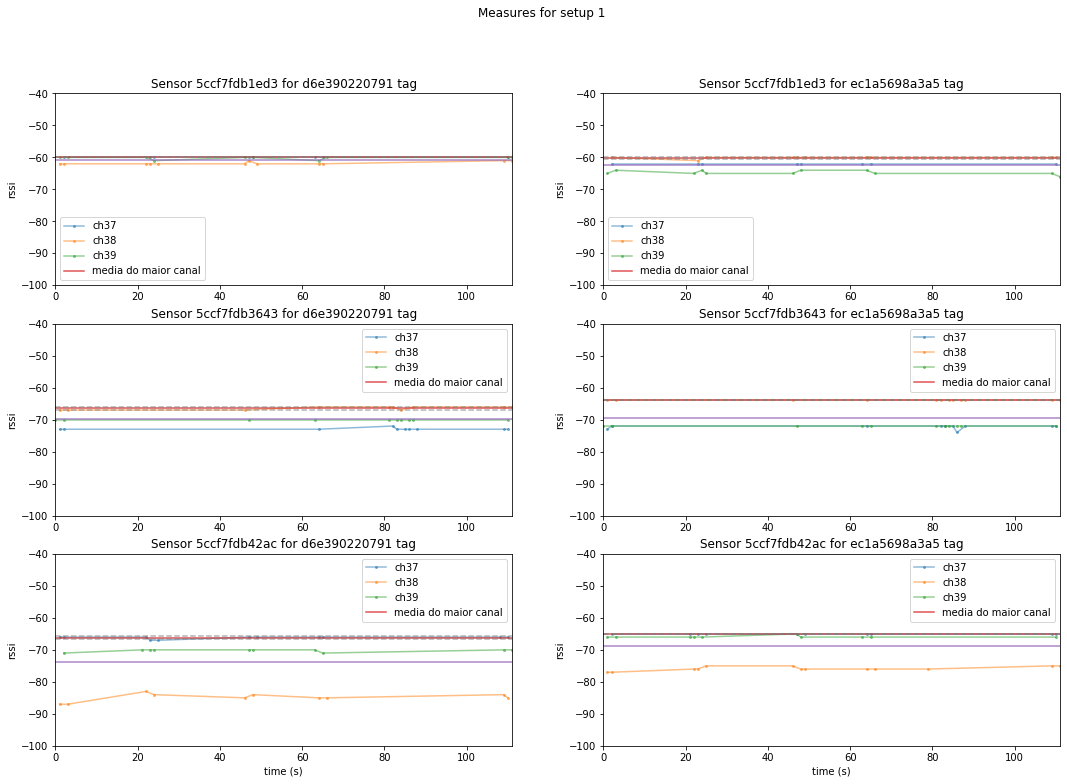

In [20]:
fig = plt.figure(figsize=(18, 12))

mean_moving = {}
max_mean_moving = {}
std_moving = {}

mean_ref = {}
max_mean_ref = {}
std_ref = {}

subp = 321
for sensor in sensors:
    plt.subplot(subp)
    
    means = [
        np.mean(moving_measures[sensor]["37"]["y"]),
        np.mean(moving_measures[sensor]["38"]["y"]),
        np.mean(moving_measures[sensor]["39"]["y"]),
    ]

    mean_moving[sensor] = np.nanmean(means)
    
    stds = [
        np.std(moving_measures[sensor]["37"]["y"]),
        np.std(moving_measures[sensor]["38"]["y"]),
        np.std(moving_measures[sensor]["39"]["y"]),
    ]

    try:
        idx = np.nanargmax(means)
    except ValueError:
        idx = 0
    max_mean_moving[sensor] = means[idx]
    std_moving[sensor] = stds[idx]
    
    for _, v in moving_measures[sensor].items():
        plt.plot(v["x"], v["y"], "o-", markersize=2, alpha=0.5)
        
    plt.plot([0, maxX], [max_mean_moving[sensor]] * 2, alpha=0.8)
    plt.plot([0, maxX], [mean_moving[sensor]] * 2, alpha=0.8)
    plt.plot([0, maxX], [max_mean_moving[sensor] + std_moving[sensor]] * 2, '--', color="gray",alpha=0.6)
    plt.plot([0, maxX], [max_mean_moving[sensor] - std_moving[sensor]] * 2, '--', color="gray",alpha=0.6)

    plt.title(f"Sensor {sensor} for {moving_tag} tag")
    plt.legend(["ch37", "ch38", "ch39", "media do maior canal"])
    plt.ylabel("rssi")
    plt.axis([0, maxX, -100, -40])
    subp += 2

plt.xlabel("time (s)")

subp = 322

for sensor in sensors:
    plt.subplot(subp)
    
    means = [
        np.mean(ref_measures[sensor]["37"]["y"]),
        np.mean(ref_measures[sensor]["38"]["y"]),
        np.mean(ref_measures[sensor]["39"]["y"]),
    ]

    mean_ref[sensor] = np.nanmean(means)

    stds = [
        np.std(ref_measures[sensor]["37"]["y"]),
        np.std(ref_measures[sensor]["38"]["y"]),
        np.std(ref_measures[sensor]["39"]["y"]),
    ]

    try:
        idx = np.nanargmax(means)
    except ValueError:
        idx = 0
    max_mean_ref[sensor] = means[idx]
    std_ref[sensor] = stds[idx]
    
    for ch, v in ref_measures[sensor].items():
        plt.plot(v["x"], v["y"], 'o-', markersize=2, alpha=0.5)
        
    plt.plot([0, maxX], [max_mean_ref[sensor]] * 2, alpha=0.8)
    plt.plot([0, maxX], [mean_ref[sensor]] * 2, alpha=0.8)
    plt.plot([0, maxX], [max_mean_ref[sensor] + std_ref[sensor]] * 2, '--', color="gray", alpha=0.6)
    plt.plot([0, maxX], [max_mean_ref[sensor] - std_ref[sensor]] * 2, '--', color="gray", alpha=0.6)

    plt.title(f"Sensor {sensor} for {ref_tag} tag")
    plt.legend(["ch37", "ch38", "ch39", "media do maior canal"])
    plt.ylabel("rssi")
    plt.axis([0, maxX, -100, -40])
    subp += 2

plt.xlabel("time (s)")
plt.suptitle(f"Measures for setup 1")

plt.show()

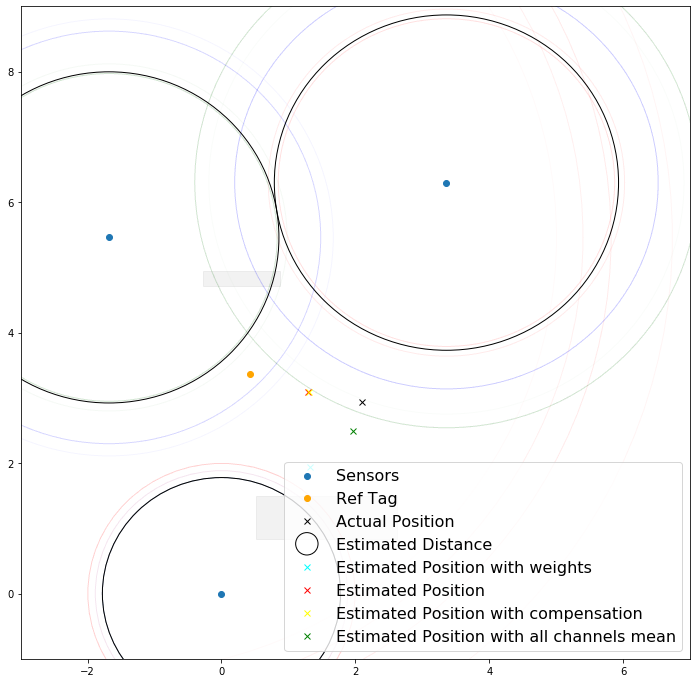

In [21]:
fig, ax = plt.subplots(figsize=(12, 12))

sensors_pos = np.array([[data['sensors'][s]['x'] for s in sensors], [data['sensors'][s]['y'] for s in sensors]])
ref_tag_pos = np.array([data["tags"][ref_tag]['x'],data["tags"][ref_tag]['y']])
mov_tag_pos = np.array([data["tags"][moving_tag][dump_idx]['x'],data["tags"][moving_tag][dump_idx]['y']])

legends = []

legends.append(plt.scatter(sensors_pos[0], sensors_pos[1], label="Sensors"))
legends.append(plt.plot(ref_tag_pos[0], ref_tag_pos[1], 'o', mec="orange", mfc="orange", label="Ref Tag")[0])
legends.append(plt.plot(mov_tag_pos[0], mov_tag_pos[1], "x", mec="black", label="Actual Position")[0])

for obs in obstacles:
    plt.gca().add_patch(ptc.Rectangle(obs[0], obs[1], obs[2],alpha=0.1,color="gray"))

actual_d = [0] * len(sensors)
actual_d_comp = [0] * len(sensors)
actual_d_all_ch = [0] * len(sensors)
for i, sensor in enumerate(sensors):
    d = {}
    for ch in ['37', '38', '39']:
        d[ch] = 10 ** ((moving_measures[sensor][ch]['y'] - Aref)/(-10 * N))
    
    for dist in d['37']:
        plt.gca().add_patch(ptc.Circle((sensors_pos[0][i], sensors_pos[1][i]), radius=dist, alpha=0.02,fill=False,color="green"))
        
    for dist in d['38']:
        plt.gca().add_patch(ptc.Circle((sensors_pos[0][i], sensors_pos[1][i]), radius=dist, alpha=0.02,fill=False,color="red"))

    for dist in d['39']:
        plt.gca().add_patch(ptc.Circle((sensors_pos[0][i], sensors_pos[1][i]), radius=dist, alpha=0.02,fill=False,color="blue"))
        
    actual_d[i] = 10 ** ((max_mean_moving[sensor] - Aref)/(-10 * N))
    actual_d_comp[i] = 10 ** ((max_mean_moving[sensor] - Aref - (max_mean_ref[sensor] - compensation_ref[sensor]))/(-10 * N))
    actual_d_all_ch[i] = 10 ** ((mean_moving[sensor] - Aref)/(-10 * N))
    circle = ptc.Circle((sensors_pos[0][i], sensors_pos[1][i]), radius=actual_d[i], alpha=1,fill=False,color="black", label="Estimated Distance")
    plt.gca().add_patch(circle)

legends.append(circle)
plt.axis(room)

A = np.zeros((len(sensors) - 1, 2))

for i in range(len(sensors) - 1):
    for j in [0, 1]:
        A[i, j] = 2 * (sensors_pos[j][i] - sensors_pos[j][-1])

b = np.zeros((len(sensors) - 1, 1))
for i in range(b.size):
    b[i] = sensors_pos[0][i]**2 - sensors_pos[0][-1] ** 2 + sensors_pos[1][i]**2 - sensors_pos[1][-1] ** 2 + actual_d[-1] ** 2 - actual_d[i] ** 2

b_chan_compensado = np.zeros((len(sensors) - 1, 1))
for i in range(b_chan_compensado.size):
    b_chan_compensado[i] = sensors_pos[0][i]**2 - sensors_pos[0][-1] ** 2 + sensors_pos[1][i]**2 - sensors_pos[1][-1] ** 2 + actual_d_comp[-1] ** 2 - actual_d_comp[i] ** 2
    
b_all_ch = np.zeros((len(sensors) - 1, 1))
for i in range(b_all_ch.size):
    b_all_ch[i] = sensors_pos[0][i]**2 - sensors_pos[0][-1] ** 2 + sensors_pos[1][i]**2 - sensors_pos[1][-1] ** 2 + actual_d_all_ch[-1] ** 2 - actual_d_all_ch[i] ** 2

Ai = np.linalg.inv(A)
pos = Ai @ b

pos_comp = Ai @ b_chan_compensado

pos_all_ch = Ai @ b_all_ch

# Check circles size and compare them
smallest_circles = actual_d.copy()
smallest_circles.sort()
smallest_circles_index = [0,0,0]

for i in range(len(smallest_circles)) :
    for j in range(len(smallest_circles)) :
        if smallest_circles[i] == actual_d[j]:
            smallest_circles_index[i] = j

distance_small_0_1 = math.sqrt((sensors_pos[0][smallest_circles_index[0]] - sensors_pos[0][smallest_circles_index[1]]) ** 2 + (sensors_pos[1][smallest_circles_index[0]] - sensors_pos[1][smallest_circles_index[1]]) ** 2 )

distance_small_0_2 = math.sqrt((sensors_pos[0][smallest_circles_index[0]] - sensors_pos[0][smallest_circles_index[2]]) ** 2 + (sensors_pos[1][smallest_circles_index[0]] - sensors_pos[1][smallest_circles_index[2]]) ** 2 )

# If there is no intersection between the smallest circle:

if (actual_d[smallest_circles_index[0]] + actual_d[smallest_circles_index[1]] < distance_small_0_1 and actual_d[smallest_circles_index[0]] + actual_d[smallest_circles_index[2]] < distance_small_0_2):



    w_0_1 = smallest_circles[0]/smallest_circles[1]
    w_0_2 = smallest_circles[0]/smallest_circles[2]


    m = (sensors_pos[1][smallest_circles_index[1]] - sensors_pos[1][smallest_circles_index[0]])/(sensors_pos[0][smallest_circles_index[1]] - sensors_pos[0][smallest_circles_index[0]])

    a_distance = distance_small_0_1 - smallest_circles[0] - smallest_circles[1]


    d_1 = a_distance * w_0_1


    delta_point_x = math.cos(math.atan(m)) * (d_1 +  smallest_circles[0])
    delta_point_y = math.sin(math.atan(m)) * (d_1 +  smallest_circles[0])


    # se ponto do menor x é menor:

    if (sensors_pos[0][smallest_circles_index[0]] < sensors_pos[0][smallest_circles_index[1]]):
        a_point_x = sensors_pos[0][smallest_circles_index[0]] + delta_point_x
    else:
        a_point_x = sensors_pos[0][smallest_circles_index[0]] - delta_point_x

    # se ponto do menor y é menor
    if (sensors_pos[1][smallest_circles_index[0]] < sensors_pos[1][smallest_circles_index[1]]):
        a_point_y = sensors_pos[1][smallest_circles_index[0]] + delta_point_y
    else:
        a_point_y = sensors_pos[1][smallest_circles_index[0]] - delta_point_y


    b_distance = math.sqrt((sensors_pos[0][smallest_circles_index[2]] - a_point_x) ** 2 + (sensors_pos[1][smallest_circles_index[2]] - a_point_y ) ** 2 ) - smallest_circles[2]

    d_2 = b_distance * w_0_2

    m = (sensors_pos[1][smallest_circles_index[2]] - a_point_y)/(sensors_pos[0][smallest_circles_index[2]] - a_point_x)

    delta_point_x = math.cos(math.atan(m)) * (d_2)
    delta_point_y = math.sin(math.atan(m)) * (d_2)



    if (a_point_x < sensors_pos[0][smallest_circles_index[2]]):
        a_point_x = a_point_x + delta_point_x
    else:
        a_point_x = a_point_x - delta_point_x


    if (a_point_y < sensors_pos[1][smallest_circles_index[2]]):
        a_point_y = a_point_y + delta_point_y
    else:
        a_point_y = a_point_y - delta_point_y

    legends.append(plt.plot(a_point_x , a_point_y , "x", mec="cyan", label="Estimated Position with weights")[0])

legends.append(plt.plot(pos[0], pos[1], "x", mec="red", label="Estimated Position")[0])
legends.append(plt.plot(pos_comp[0], pos_comp[1], "x", mec="yellow", label="Estimated Position with compensation")[0])
legends.append(plt.plot(pos_all_ch[0], pos_all_ch[1], "x", mec="green", label="Estimated Position with all channels mean")[0])
plt.legend(handles=legends, handler_map={ptc.Circle: HandlerCircle()}, loc=4, prop={'size': 16})


plt.show()


In [22]:
error = np.linalg.norm(pos.T - mov_tag_pos)
error

0.8232362225929531

In [23]:
error_2 = np.linalg.norm(pos_comp.T - mov_tag_pos)
error_2

In [0]:
error_3 = np.linalg.norm(pos_all_ch.T - mov_tag_pos)
error_3

In [0]:
error_4 = np.linalg.norm(np.array([a_point_x, a_point_y]) - mov_tag_pos)
error_4

In [0]:
pos.T, mov_tag_pos

In [0]:
A, b, sensors_pos, actual_d

In [0]:
std_moving['5ccf7fdb1ed3']
ax.transData.transform((0.24, 0))

In [0]:
fig.tight_layout()
fig.savefig(f"plots/{setup}-{dump_idx}.png")

In [0]:
a_point_x, a_point_y, pos_all_ch